<a href="https://colab.research.google.com/github/mingshey/python_projects/blob/main/refraction_image(reduced).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sym
import scipy as sci

In [3]:
def Dptimef(x, n_1, n_2, A, B, C, D):
  """
  광선이 (C, D)에서 (x, 0)를 거쳐 (A, B) 로 가는 시간의 x에 대한 변화율
  A, B: POV(관측점)의 위치
  C, D: OBJ(물체)의 위치
  x   : y=0인 수면에서 광선이 지나가는 POI(입사점)의 위치
  """
  return n_1*(-A + x)/np.sqrt(B**2 + (-A + x)**2) + n_2*(-C + x)/np.sqrt(D**2 + (C - x)**2)

In [4]:
def find_poi(pov, obj, nrel):
  """
  pov: [a, b]; 관측점의 위치
  obj: [c, d]; 물체의 위치
  nrel: POV가 속한 매질에 대한 OBJ가 속한 매질의 상대굴절률
  """
  a, b = pov
  c, d = obj
  xPOI = sci.optimize.root(lambda x: Dptimef(x, 1, nrel, a, b, c, d), d).x[0]
  return xPOI

In [21]:
# 상의 위치를 구하는 함수
# 물체의 위치와 관측점 및 상대 굴절률을 입력으로 받아 상의 위치를 반환하는 함수

def find_img(xPOI, obj, nrel):
  '''
  poi: [a, b]; 입사점의 위치
  obj: [c, d]; 물체의 위치
  nrel: POV가 속한 매질에 대한 OBJ가 속한 매질의 상대굴절률, nrel = nPOV / nOBJ
        예: POV가 n1에, OBJ가 n2에 있을 때, nrel=n2/n1
  '''
  c, d = obj
  alpha = xPOI - c
  p = (nrel**2 - 1) * (alpha/d)**2
  xi = c + p * alpha
  yi = d / nrel * ( 1 - p ) ** 1.5
  return np.array([xi, yi])

In [14]:
pov = [0, 1]
obj = [1, -1]
n1 = 1.0
n2 = 1.33
nrel = n2/n1
xpoi = find_poi(pov, obj, nrel)
img = find_img(xpoi, obj, nrel)
img
poi=[xpoi,.0]

In [15]:
ray_path = np.array([obj, poi, pov])
ray_path

array([[ 1.        , -1.        ],
       [ 0.58786712,  0.        ],
       [ 0.        ,  1.        ]])

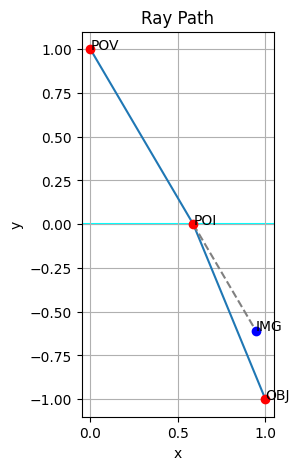

In [17]:
rpx, rpy = ray_path.T

plt.figure(figsize=(5,5))
plt.axes().set_aspect('equal')
plt.plot(rpx, rpy)
plt.scatter(rpx, rpy, c='r', zorder=3)
plt.scatter(img[0], img[1], c='b', zorder=3)
plt.plot([poi[0], img[0]], [poi[1], img[1]], c='gray', ls='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ray Path')
plt.text(obj[0], obj[1], 'OBJ')
plt.text(pov[0], pov[1], 'POV')
plt.text(poi[0], poi[1], 'POI')
plt.text(img[0], img[1], 'IMG')
plt.axhline(0, c='cyan', ls='-', zorder=1)
plt.grid()

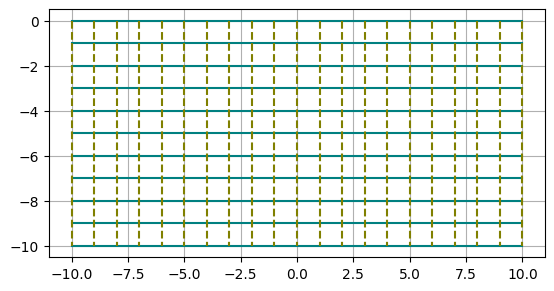

In [18]:
N = 200

class hline():
  def __init__(self, a, b, y):
    self.xs = np.linspace(a, b, N+1)
    self.ys = np.ones_like(self.xs) * y
    self.color = 'teal'
    self.ls = '-'
    self.label = None

  def set_color(self, color):
    self.color = color

  def set_linestyle(self, ls):
    self.ls = ls

  def draw(self):
    plt.plot(self.xs, self.ys, self.color, ls=self.ls, label=self.label)

class vline():
  def __init__(self, c, d, x):
    self.ys = np.linspace(c, d, N+1)
    self.xs = np.ones_like(self.ys) * x
    self.color = 'olive'
    self.ls = '--'
    self.label = None

  def set_color(self, color):
    self.color = color

  def set_linestyle(self, ls):
    self.ls = ls

  def draw(self):
    plt.plot(self.xs, self.ys, self.color, ls=self.ls, label=self.label)

class xygrid():
  def __init__(self, xrange, yrange, xnum, ynum):
    self.a, self.b = xrange
    self.c, self.d = yrange
    xstep = (xrange[1] - xrange[0]) / xnum
    ystep = (yrange[1] - yrange[0]) / ynum
    self.hors = [hline(self.a, self.b, yrange[0] + ystep * k) for k in range(ynum+1)]
    self.vers = [vline(self.c, self.d, xrange[0] + xstep * j) for j in range(xnum+1)]
    self.hlabel = None
    self.vlabel = None

  def draw(self):
    for ho in self.hors:
      ho.draw()
    for vo in self.vers:
      vo.draw()

# 수면 아래 격자 모양의 물체
xrange = [-10, 10]
yrange = [0, -10]
xnum = 20
ynum = 10

obj1 = xygrid(xrange, yrange, xnum, ynum)

obj1.hors[0].label = 'object'
obj1.vers[0].label = 'object'

plt.axes().set_aspect('equal')
obj1.draw()

plt.grid()

In [19]:
class iline():
  def __init__(self, obj):
    self.xs = obj.xs
    self.ys = obj.ys
    self.color = 'gray'
    self.ls = '-'
    self.label = None
    self.imageloc = np.empty((0, 2))
    self.OBJs = np.empty((0, 2))

  def set_color(self, color):
    self.color = color

  def set_linestyle(self, ls):
    self.ls = ls

  def calc_xy(self, POV, nrel):
    self.OBJs = np.array([self.xs, self.ys]).T
    self.imageloc = np.array([refimg(POV, obj, nrel) for obj in self.OBJs])

  def draw(self):
    plt.plot(self.imageloc.T[0], self.imageloc.T[1], self.color, ls=self.ls, label=self.label)

class refraction_image():
  def __init__(self, obj, pov, n1, n2):
    self.hlines = obj.hors
    self.vlines = obj.vers
    self.pov = pov
    self.n1 = n1
    self.n2 = n2
    self.nrel = self.n2/self.n1
    self.himgs = [iline(hl) for hl in self.hlines]
    self.vimgs = [iline(vl) for vl in self.vlines]
    self.himgs[0].label = 'image'
    self.vimgs[0].label = 'image'
    self.leged_loc = 'upper left' if self.nrel > 1 else 'lower left'

    for hi in self.himgs:
      hi.set_color('orange')
      hi.set_linestyle('-')
    for vi in self.vimgs:
      vi.set_color('brown')
      vi.set_linestyle('--')
    for hi in self.himgs:
      hi.calc_xy(self.pov, self.nrel)
    for vi in self.vimgs:
      vi.calc_xy(self.pov, self.nrel)

  def draw(self):
    plt.grid()
    plt.plot(self.pov[0], self.pov[1], 'o', color='b')
    plt.text(self.pov[0]+0.2, self.pov[1], 'POV', color='b')
    xn = self.hlines[0].xs[0]

    for hi in self.himgs:
      hi.draw()
    for vi in self.vimgs:
      vi.draw()

    plt.text(xn, 0.2, str(self.n1), color='b', va='bottom', ha='left',\
             weight='bold', backgroundcolor='white')
    plt.text(xn, -0.2, str(self.n2), color='b', va='top', ha='left', \
             weight='bold', backgroundcolor='white')

    plt.axhline(0, c='cyan', zorder=3)


    plt.legend(loc=self.leged_loc)
#

<ipython-input-3-05ccdbe4585a>:16: RuntimeWarning: divide by zero encountered in scalar divide
  p = (nrel**2 - 1) * (alpha/d)**2
<ipython-input-3-05ccdbe4585a>:18: RuntimeWarning: invalid value encountered in scalar multiply
  yi = d / nrel * ( 1 - p ) ** 1.5
<ipython-input-2-3dc778f724aa>:2: RuntimeWarning: invalid value encountered in divide
  return n_1*(-A + x)/np.sqrt(B**2 + (-A + x)**2) + n_2*(-C + x)/np.sqrt(D**2 + (C - x)**2)
<ipython-input-3-05ccdbe4585a>:16: RuntimeWarning: invalid value encountered in scalar divide
  p = (nrel**2 - 1) * (alpha/d)**2


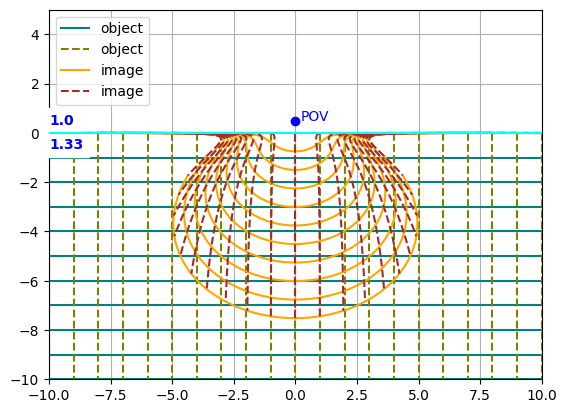

In [ ]:
pov1 = [0, 0.5]
img1 = refraction_image(obj1, pov1, 1.0, 1.33)

plt.axes().set_aspect('equal')
plt.xlim(-10, 10)
plt.ylim(-10, 5)
obj1.draw()
img1.draw()